# Part 1: Symbol Recognizer
Train a CNN to recognize 1 symbol in a given image

In [1]:
from os import listdir
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS = len(SYMBOL_SET)

In [3]:
# Helper function for One-hot encoding a symbol
def onehot(x):
    b = np.zeros(NUM_SYMBOLS)
    b[x] = 1
    return b

In [4]:
def generate_symbol(return_image=False):
    fonts = [i for i in listdir("../fonts") if i.endswith('.ttf')]
    while True:
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        font = ImageFont.truetype(f'../fonts/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
        character = SYMBOL_SET[randrange(NUM_SYMBOLS)]
        x_pos = randrange(MINX, MAXX)
        y_pos = randrange(MINY, MAXY)
        position = (x_pos, y_pos)
        coords = canvas.textbbox(position, character, font)
        canvas.text(position, character, font=font, fill=(0,0,0), anchor="la")
        rect = img.crop(coords).resize((SYMBOL_SIZE, SYMBOL_SIZE))
        x = np.array(list(rect.tobytes())).reshape(SYMBOL_SIZE, SYMBOL_SIZE, 3).astype(np.float64)/255.0
        y = onehot(int(character))
        
        if return_image:
            yield x, y, img, coords
        else:
            yield x, y

Character: 5


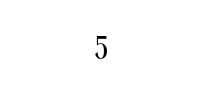

In [5]:
(x, y, image, coords) = next(generate_symbol(return_image=True))
print("Character:", int(y.argmax()))
display(image)

In [6]:
symbol_dataset = tf.data.Dataset.from_generator(generate_symbol,
            output_signature=(tf.TensorSpec(shape=(SYMBOL_SIZE, SYMBOL_SIZE, 3), dtype=tf.float64),
                             tf.TensorSpec(shape=(NUM_SYMBOLS,), dtype=tf.float32)
                             ))
symbol_dataset = symbol_dataset.batch(batch_size=32)

In [7]:
PATH = 'logs/symbol_recognizer/'
log_dir = PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

data_augmentation = models.Sequential(
  [
    layers.RandomZoom(height_factor=0.2,width_factor=0.2),
    layers.RandomTranslation(height_factor=0.2,width_factor=0.2)
  ]
)

sym_model = models.Sequential()
sym_model.add(layers.Input(shape=(SYMBOL_SIZE, SYMBOL_SIZE, 3)))
sym_model.add(data_augmentation)
sym_model.add(layers.Conv2D(8,(3,3),activation='relu'))
sym_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sym_model.add(layers.Conv2D(32,(3,3),activation='relu'))
sym_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sym_model.add(layers.Conv2D(64,(3,3),activation='relu'))
sym_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sym_model.add(layers.Flatten())
sym_model.add(layers.Dense(128, activation='relu'))
sym_model.add(layers.Dropout(0.25))
sym_model.add(layers.Dense(64, activation='relu'))
sym_model.add(layers.Dropout(0.25))
sym_model.add(layers.Dense(NUM_SYMBOLS, activation='softmax'))

sym_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.SGD(learning_rate=0.02), metrics=['accuracy'])
sym_history = sym_model.fit(symbol_dataset, epochs=100, steps_per_epoch=500, callbacks=[tensorboard_callback])
sym_model.save("../models/Symbol_Recognizer-100epochs.keras")
# sym_model = models.load_model("../models/Symbol_Recognizer-100epochs.keras")
sym_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,164 (629.55 KB)

 Trainable params: 161,162 (629.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [8]:
def get_sub_image(image, rectangle):
    return image.crop(rectangle).resize((SYMBOL_SIZE, SYMBOL_SIZE))

In [9]:
def font_image_to_x(image):
    im = np.array(list(image.tobytes())).astype(np.float64)/255.0
    return im.reshape(-1, SYMBOL_SIZE, SYMBOL_SIZE, 3)

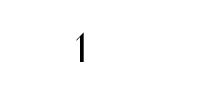

Prediction: 1


In [10]:
(x, y, image, coords) = next(generate_symbol(return_image=True))
display(image)
sub_img = get_sub_image(image, coords)
y_pred = sym_model.predict(font_image_to_x(sub_img), verbose=False)
print("Prediction:", y_pred.argmax())

In [11]:
# Evaluate the Symbol Recognizer
test_size = 1000
count = 0
for i in range(test_size):
    (x, y, image, coords) = next(generate_symbol(return_image=True))
    sub_img = get_sub_image(image, coords)
    y_pred = sym_model.predict(font_image_to_x(sub_img), verbose=False)
    if y.argmax() != y_pred.argmax():
        print("Truth:", y.argmax())
        print("Predicted:", y_pred.argmax())
        count += 1
        canvas = ImageDraw.Draw(image)
        canvas.rectangle(list(boxes_pred[0]), outline=(255,0,0), width=1)
        display(image)
print("Accuracy:", (test_size-count)*100/test_size)

Accuracy: 100.0
